<a href="https://colab.research.google.com/github/VJurczak/SiOC_lab/blob/main/Denoising_compression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Saving mops.jpg to mops (11).jpg


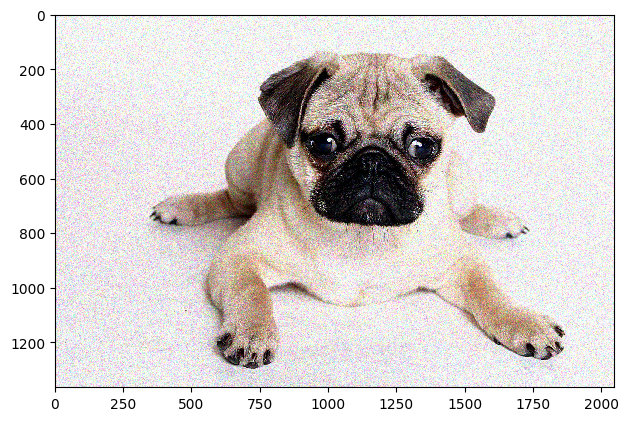

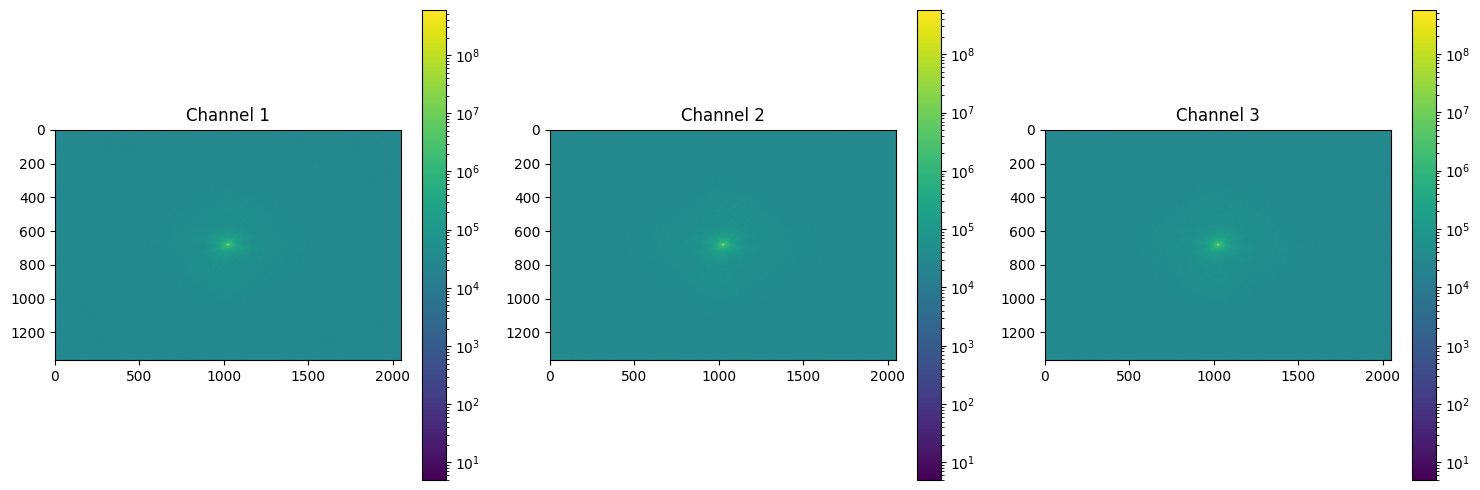

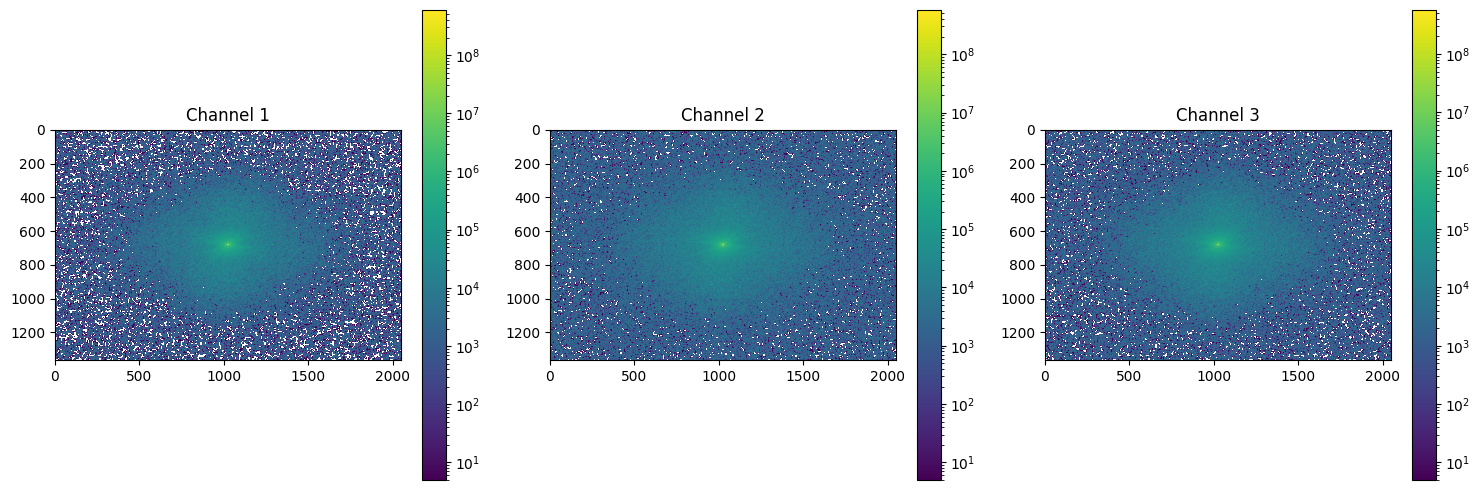

In [36]:
import numpy as np
from skimage import io
import cv2
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm
from scipy.fft import fft2, fftshift
from scipy import fftpack
from PIL import Image
import pywt
from google.colab import files
from google.colab.patches import cv2_imshow

uploaded = files.upload()
image_path = next(iter(uploaded))
image = io.imread(image_path)

def poissoning(image, lambda_value=64):
    noisy_image = np.zeros_like(image, dtype=np.float64)
    for i in range(image.shape[2]):
        noisy_channel = np.random.poisson(image[:, :, i] / 255.0 * lambda_value) / lambda_value * 255.0
        noisy_image[:, :, i] = np.clip(noisy_channel, 0, 255)
    noisy_image = noisy_image.astype(np.uint8)
    return noisy_image

def poissoning_gray(image, lambda_value=64):
    noisy_image = np.zeros_like(image, dtype=np.float64)
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            noisy_pixel = np.random.poisson(image[i, j] / 255.0 * lambda_value) * 255.0 / lambda_value
            noisy_image[i, j] = np.clip(noisy_pixel, 0, 255).astype(np.uint8)

    return noisy_image



#transformacja falkowa
def wavelet_denoise(image,threshold = 0.1):


    coeffs2 = pywt.dwt2(image, 'bior1.3')

    # Wartości progowe dla współczynników
    coeffs2 = tuple(map(lambda x: pywt.threshold(x, threshold*np.max(np.abs(x)), mode='soft'), coeffs2))

    # Odtworzenie odszumionego obrazu z przekształconych współczynników
    denoised_image = pywt.idwt2(coeffs2, 'bior1.3')


    denoised_image = np.round(denoised_image).astype(np.uint8)

    return denoised_image



#zaszumianie obrazu
noised_image = poissoning(image, 64)
io.imshow(noised_image)
noised_image.shape

#transformaty Fouriera
def D_TF(image):
    abs_val = np.abs(image)
    plt.figure(figsize=(15, 5))
    for i in range(image.shape[2]):
        plt.subplot(1, 3, i + 1)
        plt.imshow(fftshift(abs_val[:, :, i]), norm=LogNorm(vmin=5))
        plt.title(f"Channel {i + 1}")
        plt.colorbar()
    plt.tight_layout()

img_Fourier = np.fft.fft2(noised_image, axes=(0, 1))
D_TF(img_Fourier)

def adaptive_filter(channel, threshold_factor=0.2):
    mean_amp = np.mean(np.abs(channel))
    std_amp = np.std(np.abs(channel))
    threshold = threshold_factor * std_amp
    channel[np.abs(channel) < threshold] = 0
    return channel

def denoising(image, threshold_factor=0.2):
    denoised_img = np.zeros_like(image, dtype=np.complex128)
    for i in range(image.shape[2]):
        denoised_img[:, :, i] = adaptive_filter(image[:, :, i], threshold_factor)

    return denoised_img

denoised_image_TF = denoising(img_Fourier, threshold_factor=0.2)
D_TF(denoised_image_TF)

# Funkcja odwrotna do transformaty Fouriera
denoised_image = np.fft.ifft2(denoised_image_TF, axes=(0, 1)).real

image_gray = cv2.imread(image_path,cv2.IMREAD_GRAYSCALE)
noised_image_gray = poissoning_gray(image_gray,64)


wavelet_image = wavelet_denoise(noised_image_gray,0.2)

denoised_image_normalized = np.zeros_like(denoised_image, dtype=np.float64)
for i in range(denoised_image.shape[2]):
    denoised_image_normalized[:, :, i] = (denoised_image[:, :, i] - np.min(denoised_image[:, :, i])) / (np.max(denoised_image[:, :, i]) - np.min(denoised_image[:, :, i])) * 255

wavelet_image_normalized = (wavelet_image - np.min(wavelet_image)) / (np.max(wavelet_image) - np.min(wavelet_image)) * 255


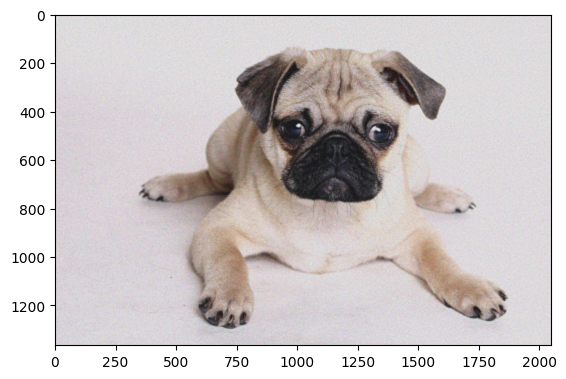

In [40]:
plt.imshow(denoised_image_normalized.astype(np.uint8))
plt.show()

/usr/local/lib/python3.10/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Float image out of standard range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


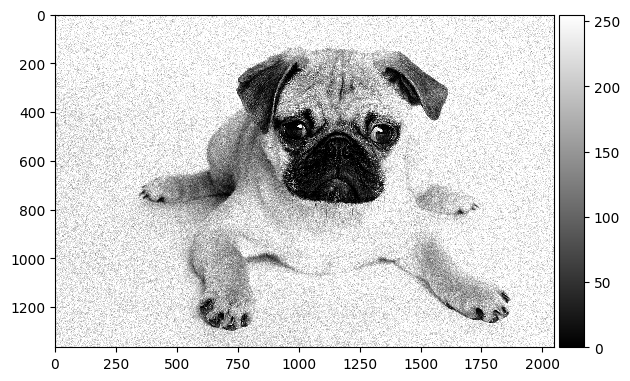

In [41]:

io.imshow(noised_image_gray, cmap = 'gray')

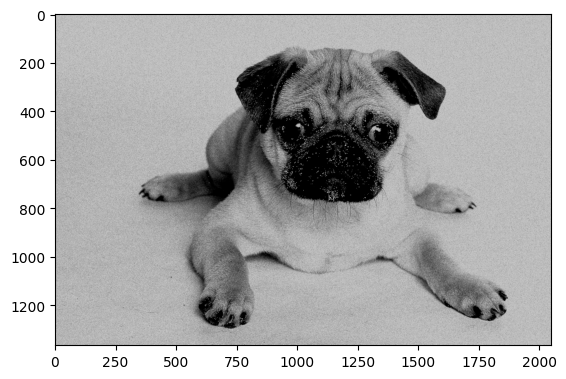

In [44]:
plt.imshow(wavelet_image_normalized.astype(np.uint8),cmap='gray')
plt.show()

Saving mops.jpg to mops.jpg
Gray Image - MAE: 0.17085992401523742, Compression Ratio: 1.0
RGB Image - MAE: 0.1712789815211313, Compression Ratio: 1.0


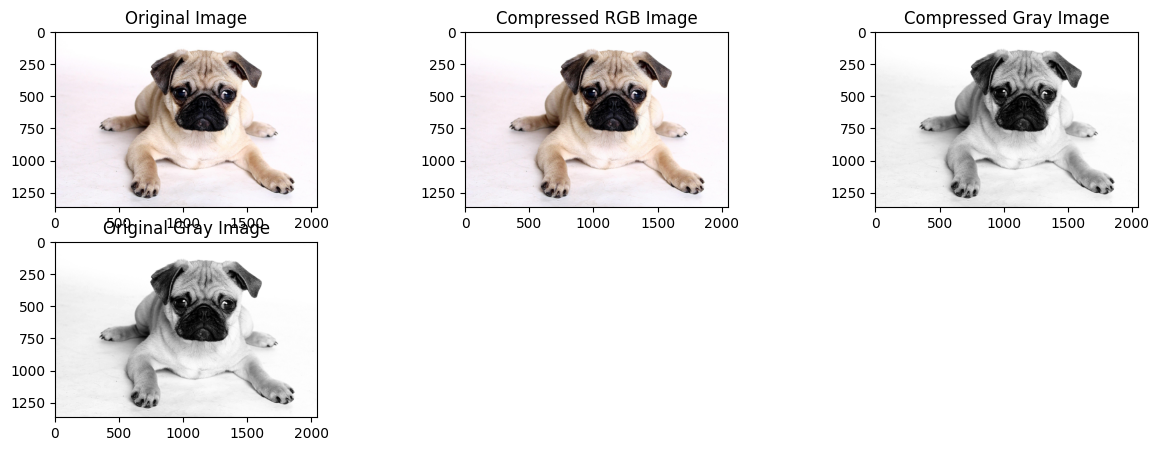

In [1]:
import numpy as np
import cv2
from google.colab import files
from google.colab.patches import cv2_imshow
from skimage import io
import matplotlib.pyplot as plt
from scipy.fft import fft2, fftshift
from scipy import fftpack

uploaded = files.upload()
image_path = next(iter(uploaded))
original_image = plt.imread(image_path)

def compress(image, comp_ratio):

    fimage = np.fft.fft2(image)

    #Sortowanie amplitud
    sort_fimage = np.sort(np.abs(fimage.flatten()))

    # Obliczenie progu na podstawie współczynnika kompresji
    threshold = sort_fimage[int((1 - comp_ratio) * len(sort_fimage))]

    fimage[np.abs(fimage) < threshold] = 0


    compressed = np.fft.ifft2(fimage).real
    return compressed

def compress_RGB(image, r):
    R, G, B = image[:,:,0], image[:,:,1], image[:,:,2]
    cR, cG, cB = compress(R, r), compress(G, r), compress(B, r)

    return np.dstack((cR, cG, cB))

def calculate_metrics(original, compressed):

    mae = np.mean(np.abs(original - compressed))

    compression_ratio = np.prod(original.shape) / np.count_nonzero(compressed)

    return mae, compression_ratio


compression_ratio = 0.9

gray_im = cv2.cvtColor(original_image, cv2.COLOR_BGR2GRAY)
compressed_gray = compress(gray_im, compression_ratio)
compressed_RGB = compress_RGB(original_image, compression_ratio)


mae_gray, compression_ratio_gray = calculate_metrics(gray_im, compressed_gray)
mae_RGB, compression_ratio_RGB = calculate_metrics(original_image, compressed_RGB)


print(f'Gray Image - MAE: {mae_gray}, Compression Ratio: {compression_ratio_gray}')
print(f'RGB Image - MAE: {mae_RGB}, Compression Ratio: {compression_ratio_RGB}')

plt.figure(figsize=(15, 5))

plt.subplot(231)
plt.imshow(original_image)
plt.title('Original Image')

plt.subplot(232)
plt.imshow(compressed_RGB.astype(np.uint8))
plt.title('Compressed RGB Image')

plt.subplot(233)
plt.imshow(compressed_gray.astype(np.uint8), cmap='gray')
plt.title('Compressed Gray Image')

plt.subplot(234)
plt.imshow(gray_im, cmap='gray')
plt.title('Original Gray Image')

plt.show()